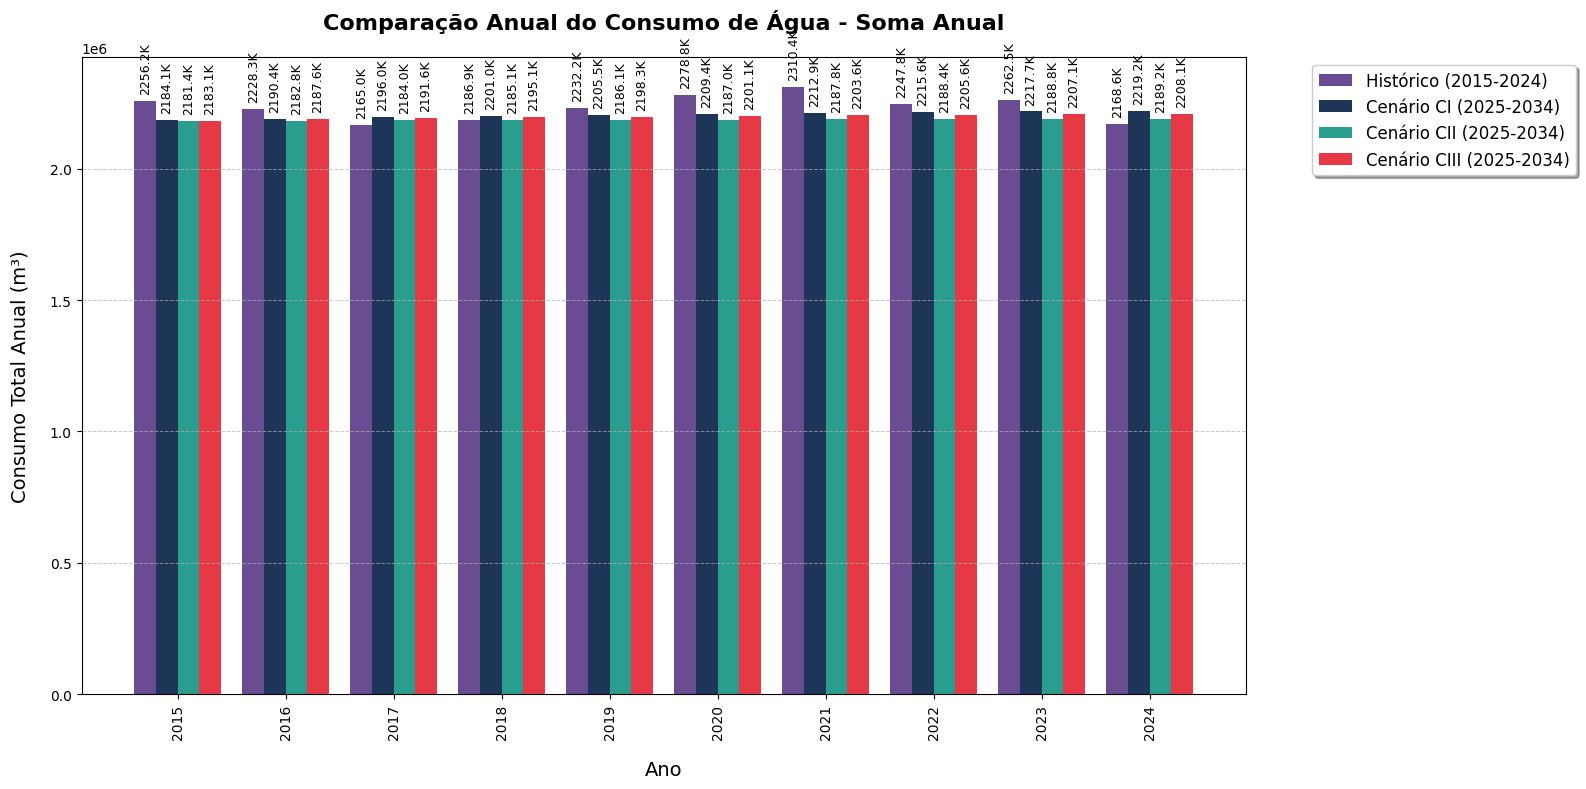

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

path = 'C:\\Users\\Edmilson\\Gama_Workspace2\\ABMS-WP'

# 1. Carregar dados dos cenários
scenario_file = os.path.join(path, 'resultados\\dados_simulacao3.csv')
df_scenarios = pd.read_csv(scenario_file)
df_scenarios.columns = ['Month/Year', 'Scenario CI', 'Scenario CII', 'Scenario CIII']
df_scenarios['Date'] = pd.to_datetime(df_scenarios['Month/Year'], format='%m/%Y')

# 2. Carregar dados históricos
historical_file = os.path.join(path, 'includes\\Tabela_consumo_Itapua_120m_por_mes.csv')
df_historical = pd.read_csv(historical_file, sep=';')
df_historical['Date'] = pd.to_datetime(df_historical['data'])
df_scenarios = df_scenarios[df_scenarios['Date'] < pd.to_datetime('2035-01-01')]
df_historical.rename(columns={'consumo': 'Historical Consumption'}, inplace=True)

# 3. Função para somar dados anualmente
def sum_yearly(df, value_column):
    df_year = df.copy()
    df_year['Year'] = df_year['Date'].dt.year
    return df_year.groupby('Year')[value_column].sum().reset_index()

# 4. Somar dados anualmente
df_historical_sum = sum_yearly(df_historical, 'Historical Consumption')
df_ci_sum = sum_yearly(df_scenarios[['Date', 'Scenario CI']].rename(columns={'Scenario CI': 'Value'}), 'Value')
df_cii_sum = sum_yearly(df_scenarios[['Date', 'Scenario CII']].rename(columns={'Scenario CII': 'Value'}), 'Value')
df_ciii_sum = sum_yearly(df_scenarios[['Date', 'Scenario CIII']].rename(columns={'Scenario CIII': 'Value'}), 'Value')

# 5. Combinar todos os dados e remover 2035
df_combined = pd.DataFrame({
    'Year': df_historical_sum['Year'],
    'Historical': df_historical_sum['Historical Consumption'],
    'Scenario CI': df_ci_sum['Value'],
    'Scenario CII': df_cii_sum['Value'],
    'Scenario CIII': df_ciii_sum['Value']
})

# Remover ano de 2035 se existir
df_combined = df_combined[df_combined['Year'] < 2035]

# 6. Determinar períodos para as legendas
historical_years = f"{df_historical['Date'].dt.year.min()}-{df_historical['Date'].dt.year.max()}"
scenario_years = f"{df_scenarios['Date'].dt.year.min()}-{df_scenarios['Date'].dt.year.max()}"

# 7. Configurar o gráfico
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Cores e configurações
colors = {
    'Historical': '#6A4C93',
    'Scenario CI': '#1D3557',
    'Scenario CII': '#2A9D8F',
    'Scenario CIII': '#E63946'
}

bar_width = 0.2
years = df_combined['Year']
x = np.arange(len(years))

# 8. Plotar as barras com legendas atualizadas
bars_hist = ax.bar(x - 1.5*bar_width, df_combined['Historical'], width=bar_width, 
                   color=colors['Historical'], label=f'Histórico ({historical_years})')
bars_ci = ax.bar(x - 0.5*bar_width, df_combined['Scenario CI'], width=bar_width, 
                 color=colors['Scenario CI'], label=f'Cenário CI ({scenario_years})')
bars_cii = ax.bar(x + 0.5*bar_width, df_combined['Scenario CII'], width=bar_width, 
                  color=colors['Scenario CII'], label=f'Cenário CII ({scenario_years})')
bars_ciii = ax.bar(x + 1.5*bar_width, df_combined['Scenario CIII'], width=bar_width, 
                   color=colors['Scenario CIII'], label=f'Cenário CIII ({scenario_years})')

# 9. Configurar eixo X com rótulos verticais
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=90, ha='center', va='top')

# 10. Elementos gráficos
plt.title('Comparação Anual do Consumo de Água - Soma Anual', 
         fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Ano', fontsize=14, labelpad=15)
plt.ylabel('Consumo Total Anual (m³)', fontsize=14, labelpad=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, axis='y')

# 11. Adicionar valores nas barras (na vertical)
def add_vertical_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height/1000:.1f}K',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 5),
                   textcoords="offset points",
                   ha='center', va='bottom', 
                   fontsize=9, rotation=90)

add_vertical_labels(bars_hist)
add_vertical_labels(bars_ci)
add_vertical_labels(bars_cii)
add_vertical_labels(bars_ciii)

# 12. Configurar legenda
plt.legend(fontsize=12, framealpha=1, shadow=True, 
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()